# Fundamentos de Aprendizaje Automático y Reconocimiento de Patrones
***
# Práctico 5

In [1]:
# Se importan las bibliotecas que se utilizarán
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


## Objetivos

- Implementar desde cero una red neuronal de dos capas
- Utilizar la implementación para:
    - Clasificar datos sintéticos 
    - Clasificar entre imágenes de gatos y no gatos
- Adquirir cierta intuición sobre las fronteras de decisión determinadas por una red neuronal

## Lista de ejercicios

[Ejercicio 1](#Ejercicio1): implementación de una red neuronal de dos capas       
[Ejercicio 2](#Ejercicio2): jugando con tensorflow playground   

<a id="Ejercicio1"></a>
## Ejercicio 1: Implementación de una red neuronal de dos capas

### Notación:

- En general, la arquitectura de una red de $L$ capas de define mediante el vector $[d^{(0)},d^{(1)},\ldots, d^{(L)}]$, siendo $d^{l}$ el número de nodos de la capa $l$.
- En una red neuronal de dos capas, es decir con $L=2$, con $l=0$ se referirá a la entrada (no se considera una capa) y con $l=2$ se referirá a la capa de salida.     
- A la señal de entrada a la activación $j$ de la capa $l$ se le llamará $s_j^{(l)}$ y a la de salida $x_j^{(l)}$. Así, por ejemplo:
    - La coordenada $j$ del vector de características $\mathbf{x^{(0)}}$ es $x_j^{(0)}$     
    - La coordenada $j$ del vector de salida $\mathbf{x^{(L)}}$ es $x_j^{(L)}$

In [2]:
# funciones auxiliares (Ejecutar y seguir)
def error_relativo(x, y):
    ''' devuelve el error relativo'''
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def calcular_gradiente_numerico_array(f, x, df, h=1e-5):
    '''
    Evalúa el gradiente numérico para una función que acepta un arreglo numpy y
    devuelve un arreglo numpy.
    '''
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


def calcular_gradiente_numerico(f, x, verbose=True, h=0.00001):
    '''
    Evalúa el gradiente numérico de f en x
    - f es una función que recibe un solo argumente
    - x es el punto (numpy array) en que se evalúa el gradiente
    '''
    
    # se inicializa el gradiente 
    grad = np.zeros_like(x)
    # se define un iterador sobre todos los elementos de x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # se evalúa la función en x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # se suma h al valor original de x
        fxph = f(x) # se evalúa f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # se evalúa f(x - h)
        x[ix] = oldval # se restaura el valor original de x

        # se calcula la derivada parcial con la fórmula centrada
        grad[ix] = (fxph - fxmh) / (2 * h) 
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

## Descripción del ejercicio

Se implementarán algunos de los elementos constitutivos de una red neuronal que más se utilizan en la práctica.  Con ellos se construirán un par de redes neuronales de dos capas. En este ejercicio se limitará la profundidad de la red a 2 para evitar entrar en los detalles de implementación propios de una red muy general. No obstante, los bloques a implementar se diseñaron de forma que conceptualmente sean similares a los que se utilizarían en una red neuronal más profunda. A continuación se muestra un diagrama de bloques de la red neuronal que se implementará y se describen los distintos bloques.

<img src="img/diagrama_de_bloques.png" alt="drawing" width="500"/>

- **Inicializar parámetros:** Inicializa los parámentros de la red. A los pesos de la capa $l$ de la red le llamaremos $W_l$, $b_l$ con $l=1,2$. 
- **Propagación hacia adelante:** La *propagación hacia adelante*  o *forward propagation* consiste en estimar la salida de la red a partir de la entrada. Cada nodo o capa de la red tiene un método *forward* asociado. En este ejercicio se implementarán los métodos forward asociados a los siguientes bloques:
        - Afin
        - Activación 
        - Afin --> Activación
        
- **Loss:** Calcula el valor de la función de costo a optimizar. Se implementarán dos funciones de costo:
        - Entropía cruzada
        - Error cuadrático medio
- **Propagación hacia atrás:** Durante la *propagación hacia atrás* o *backpropagation* se calculan los gradientes necesarios para actualizar los parámetros de la red. Se implementarán métodos *backward* para los siguientes bloques:
        - Afin
        - Activación 
        - Afin --> Activación
- **Update:** Es el boque encargado de actualizar los parámetros. Para ello utiliza los gradientes calculados durante la *propagación hacia atrás* y un método de optimización. En este práctico se utilizará *descenso por gradiente* como método de optimización.

## 1- Bloque de Inicialización

Se implementará el bloque de inicialización para el caso de una red neuronal de dos capas con la siguiente estructura:    
  Afín --> Activación 1 --> Afín --> Activacion 2        

**Ejercicio:** Completar la implementación de `inicializar_pesos()`. Los pesos $W_l$ serán inicializados en valores aleatorios pequeños. Los pesos correspondientes a términos de *bias* se inicializarán a cero.

In [3]:
def inicializar_pesos(d_0, d_1, d_2, tipo='aleatoria', std_ruido=0.01, semilla=1):
    """
    Entrada:
        d_0: dimensión del vector de características
        d_1: número de nodos de la capa oculta
        d_2: número de nodos de la capa de salida
        tipo: string que indica el tipo de inicialización a utilizar en los pesos
            'aleatoria': inicializa los pesos a valores aleatorios con distribución
                         gaussiana. Los términos de bias se inicializan a cero.
        std_rudio: desviación estandar del ruido gaussiano
        semilla: semilla a utilizar para generar los valores aleatorios
    
    Salida:
        diccionario con los siguientes pares clave-valor:
            W1: matriz de pesos de la capa 1 de tamaño (d_0, d_1)
            b1: vector de bias de la capa 1 de tamaño (d_1)
            W2: matriz de pesos de capa 2 de tamaño (d_1, d_2)
            b2: vector de bias de la capa 2 de tamaño (d_2)
    """
    
    np.random.seed(semilla)
        
    if tipo == 'aleatoria':
        
        ####################################################################################
        ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
        ####################################################################################
        W1 = np.random.normal(size=(d_0, d_1))*std_ruido
        b1 = np.zeros(d_1)
        W2 = np.random.normal(size=(d_1, d_2))*std_ruido
        b2 = np.zeros(d_2)
    
        ####################################################################################
        ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
        ####################################################################################
    
    assert(W1.shape == (d_0, d_1 ))
    assert(b1.shape == (d_1,))
    assert(W2.shape == (d_1, d_2))
    assert(b2.shape == (d_2,))
    
    # Se genera el diccionario con los valores inicializados
    parametros = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2}
    
    return parametros    

In [4]:
# Se testea la inicialización con pesos aleatorios
parametros = inicializar_pesos(3,6,1)

W1_correcto = np.array([[ 0.01624345, -0.00611756, -0.00528172, -0.01072969,  0.00865408, -0.02301539],
                         [ 0.01744812, -0.00761207,  0.00319039, -0.0024937,   0.01462108, -0.02060141],
                         [-0.00322417, -0.00384054,  0.01133769, -0.01099891, -0.00172428, -0.00877858]])
b1_correcto = np.array([0., 0., 0., 0., 0., 0.])
W2_correcto = np.array([[ 0.00042214] , [ 0.00582815], [-0.01100619], [ 0.01144724], [ 0.00901591], [ 0.00502494]])
b2_correcto = np.array([0.])

# Se compara la salida con la nuestra. El error debería ser e-6 o menos.
print('Testeando la incialización aleatoria:')
print('Diferencia en W1: ', error_relativo(parametros['W1'], W1_correcto))
print('Diferencia en b1: ', error_relativo(parametros['b1'], b1_correcto))
print('Diferencia en W2: ', error_relativo(parametros['W2'], W2_correcto))
print('Diferencia en b2: ', error_relativo(parametros['b2'], b2_correcto))

Testeando la incialización aleatoria:
Diferencia en W1:  7.528514403884451e-07
Diferencia en b1:  0.0
Diferencia en W2:  3.0000138227282463e-06
Diferencia en b2:  0.0


**Observación:** *La inicialización de pesos en este caso fue aleatoria. Con redes de pocas capas esta inicialización suele producir buenos resultados. Sin embargo, a medida que aumenta la profundidad de la red la correcta inicialización de los parámetros adquiere una relevancia mayor. Quien quiera profundizar en la importancia de la inicialización en el caso de redes profundas puede consultar:* 

* [Glorot, Xavier, and Yoshua Bengio. “Understanding the difficulty of
    training deep feedforward neural networks.” International Conference on Artificial Intelligence and Statistics. 2010.](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
* [He, Kaiming, et al. “Delving deep into rectifiers: Surpassing human-level
    performance on imagenet classification.” arXiv preprint arXiv:1502.01852 (2015).](https://arxiv.org/pdf/1502.01852v1.pdf)

## 2- Bloques Forward

En esta sección se implementarán los métodos *forward* de los componentes de la red neuronal de dos capas que vamos a utilizar. Observar que la capa oculta tiene un número $d^{(1)}$ de nodos mientras que la de salida tiene 1 un solo nodo. Además observar que en cada nodo se realiza una *transformación afin* de los datos de entrada y luego de pasa el resultado por una *función de activación*.

<img src="img/red_dos_capas.png" alt="drawing" width="600"/>

En particular, se implementarán los métodos *forward* de los siguientes bloques: 

- Bloque Afín  
- Bloque Activación donde la activación puede ser ReLU, Sigmoide o TangenteH.
- Bloque Afín -> Activación  

### 2.1 - Forward Afín

La señal de entrada a la activación de la capa $\textit{l}$ puede escribirse como:

$$
\mathbf{s}^{(l)}=\left( W^{(l)} \right)^T \mathbf{x}^{(l-1)}+ \mathbf{b}^{(l)}   \tag{1}
$$

donde $\mathbf{s}^{(l)}$ y $\mathbf{b}^{(l)}$ son vectores de tamaño $d^{(l)}$, $\mathbf{x}^{(l-1)}$  es un vector de tamaño $d^{(l-1)}$ y $W^{(l)}$ es una matriz de tamaño $d^{(l-1)} \times d^{(l)}$.

**Observación:** *Esta forma de escribir $\mathbf{s}^{(l)}$ es levemente distinta a la expresión del libro, en la que todos los parámetros de la capa se agrupan en una matriz $W^{(l)}$ de tamaño $d^{(l-1)+1} \times d^{(l)}$. En esta expresión se desacoplan los parámetros de bias y se indican mediante el vector $\mathbf{b}^{(l)}$. Una ventaja práctica que tiene desacoplar los parámetros de bias es que $\mathbf{x}^{(l)}=\theta \left(\mathbf{s}^{(l)}\right) $ en vez de la expresión en coordenadas homogéneas $\mathbf{x}^{(l)}= \left[ 1 , \left( \theta \left(\mathbf{s}^{(l)}\right) \right)^T \right]^T $ que utiliza el libro del curso.*

La ecuación (1) es válida cuando la entrada a la capa es un único vector $\mathbf{x}^{(l-1)}$. En la práctica es más habitual procesar un $\textit{batch}$ de vectores de entrada a la vez, por lo tanto es deseable contar con una expresión que genere la salida para todos los vectores de entrada a la vez. Al evitar la utilización de un bloque $\textit{for}$ que itere por cada una de las muestras del $\textit{batch}$ se mejora la eficiencia de la implementación.   


La versión de la ecuación (1) que actúa sobre un conjunto de muestras a la vez es la siguiente:

$$
S^{(l)} = X^{(l-1)}W^{(l)} +b^{(l)}\tag{2}
$$

donde $X^{[0]} = X$, siendo X una matriz que contiene un vector de características en cada fila.

**Ejercicio**: Implementar el método `afin_forward()` utilizando la versión eficiente dada por la ecuación (2).

In [5]:
def afin_forward(X, W, b):
    """
    Implementa la propagación hacia adelante en una capa afin.

    Entrada:
        X: matriz de tamaño (N, dim capa anterior) que en cada fila contiene un vector de
           activaciones de la capa anterior (o datos de entrada)
        W: matriz de pesos de tamaño (dim de capa anterior, dim de capa actual) 
        b: vector de bias de tamaño (dim de la capa actual,)

    Salida:
        S: matriz de tamaño (N, dim de capa actual) que contiene
           los scores o señal de entrada a la activación  
        cache: (X, W, b) tupla que contiene X, W y b. 
               Son almacenados para calcular el paso backward eficientemente
    """
    
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################

    S = X@W + b

    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    
    assert(S.shape == (X.shape[0], W.shape[1] ))
    cache = (X, W, b)
    
    return S, cache

In [6]:
# Se testea afin_forward (solo la salida)

num_muestras = 2
dim_entrada = 120
dim_salida = 3

x = np.linspace(-0.1, 0.5, num=num_muestras * dim_entrada).reshape(num_muestras, dim_entrada)
w = np.linspace(-0.2, 0.3, num=dim_entrada *dim_salida ).reshape(dim_entrada, dim_salida)
b = np.linspace(-0.3, 0.1, num=dim_salida)

S, _ = afin_forward(x, w, b)
S_correcto = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Se compara la salida con la nuestra. El error debería dar e-9 o menos.
print('Testeando afin_forward:')
print('diferencia: ', error_relativo(S, S_correcto))

Testeando afin_forward:
diferencia:  9.769849468192957e-10


### 2.2 - Funciones de activación

En este notebook se implementarán tres de las funciones de activación más utilizadas:

- **Sigmoide**: $\sigma(S) = \sigma(X W  + b) = \frac{1}{ 1 + e^{-(X W  + b)}}$. Esta función devuelve, además de la activación resultante, la variable cache que contiene la señal `S` que dio lugar a la activación (se utiilza luego durante la propagación hacia atrás).

``` python
X, cache = sigmoid(S)
```

- **Tangente Hiperbólica**: $\tanh(S) = \frac{e^S-e^{-S}}{e^S+e^{-S}}$. Esta función devuelve, además del resultado de *np.tanh(S)*, la variable cache que contiene la señal `S` que dio lugar a la activación (se utiilza luego durante la propagación hacia atrás).       

``` python
X, cache = tanh(S)
```


- **Rectified Linear Unit**:  $ReLU(S) = max(0, S)$.  Al igual que en el caso de la activación sigmoide, esta función devuelve además de la activación resultante, la variable cache que contiene la señal `S` que dio lugar a la activación (se utiilza luego durante la propagación hacia atrás).

``` python
X, cache = relu(Z)
```

In [7]:
def sigmoide(S):
    """
    Implementa la activación sigmoide
    
    Entrada:
        S: arreglo numpy que contiene las entradas a la activación. 
           Las dimensiones de entrada no están definidas.
    
    Salida:
        X: arreglo del mismo tamaño que S que contiene la salida de sigmoid(S) 
        cache: devuelve S para utilizar durante la propagación hacia atrás
    """
    
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################

    X = 1/(1 + np.exp(-S.copy()))
    cache = S.copy()
    
    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    assert X.shape == S.shape, 'La entrada y la salida deben ser del mismo tamaño'
    return X, cache

In [8]:
# Se testea sigmoide() 

S = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

X, _ = sigmoide(S)
X_correcto = np.array([[0.37754067, 0.39913012, 0.42111892, 0.44342513],
                         [0.46596182, 0.48863832, 0.51136168, 0.53403818],
                         [0.55657487, 0.57888108, 0.60086988, 0.62245933]])

# Se compara la salida con la nuestra. El error debería ser del orden de e-8
print('Testeando la función sigmoide()')
print('Diferencia: ', error_relativo(X, X_correcto))


Testeando la función sigmoide()
Diferencia:  5.157221295671855e-09


In [9]:
def tanh(S):
    """
    Implementa la activación tangente hiperbólica
    
    Entrada:
        S: arreglo numpy que contiene las entradas a la activación. 
           Las dimensiones de entrada no están definidas.
    
    Salida:
        X: arreglo del mismo tamaño que S que contiene la salida de tanh(S) 
        cache: devuelve S para utilizar durante la propagación hacia atrás
    """
    
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################

    X = (np.exp(S.copy()) - np.exp(-S.copy()))/(np.exp(S.copy()) + np.exp(-S.copy()))
    cache = S.copy()
    
    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    assert X.shape == S.shape, 'La entrada y la salida deben ser del mismo tamaño'
    return X, cache

In [10]:
# Se testea tanh() 

S = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

X, _ = tanh(S)
X_correcto = np.array([[-0.46211716, -0.38770051, -0.30786199, -0.22343882],
                         [-0.13552465, -0.04542327,  0.04542327,  0.13552465],
                         [ 0.22343882,  0.30786199,  0.38770051, 0.46211716]])

# Se compara la salida con la nuestra. El error debería ser del orden de e-8
print('Testeando la función tanh()')
print('Diferencia: ', error_relativo(X, X_correcto))


Testeando la función tanh()
Diferencia:  3.829228808681821e-08


In [11]:
def relu(S):
    '''
    Implementa la activación relu
    
    Entrada:
        S: arreglo numpy que contiene las entradas a la activación. 
           Las dimensiones de entrada no están definidas.
    
    Salida:
        X: arreglo del mismo tamaño que S que contiene la salida de relu(S) 
        cache: devuelve S para utilizar durante la propagación hacia atrás
    '''
    
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################

    X = S.copy()*0
    
    for i in range(S.shape[0]): 
        for j in range(S.shape[1]):
            if S[i,j] > 0:
                X[i,j] = S[i,j].copy()
        
    cache = S.copy()
    
    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    assert(X.shape == S.shape)
        
    return X, cache

In [12]:
# Testeando la función relu()

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

X, _ = relu(x)
X_correcto = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Se compara la salida con la nuestra. El error debería ser del orden de e-8
print('Testeando la función relu()')
print('Diferencia: ', error_relativo(X, X_correcto))

Testeando la función relu()
Diferencia:  4.999999798022158e-08


### 2.3 - Aplicación conjunta de capa afin y activación

Cuando se implementan redes profundas es conveniente agrupar varias funciones en una sola operación. Para ejemplificar, en este caso crearemos una capa que aplique la transformación lineal y una de las activaciones disponibles. 

**Ejercicio**: Implementar la propagación hacia adelante de una capa *Afin->Activacion*. El método `afin_activacion_forward()` implementa la operación:

$$
X^{[l]} = \theta(S^{(l)}) = \theta(X^{(l-1)}W^{(l)} +b^{(l)})
$$

donde la activación $\theta(\cdot)$ será alguna de las implementadas. Se deberá hacer uso de `afin_forward()` y de la función de activación pasada como argumento. 

In [13]:
def afin_activacion_forward(X_prev, W, b, activacion):
    """
    Implementa la propagación hacia adelante para una capa Afin->Activación 
    Entrada:
        X_prev: arreglo de tamaño (N, dim capa anterior) que contiene la 
                activación de la capa anterior (o datos de entrada):          
        W: matriz de pesos de tamaño (dim de capa anterior, dim de capa actual)  
        b: vector de bias de tamaño (dim de la capa actual)
        activacion: la activacion a utilizar en esta capa se indica con uno de los 
                    siguientes strings: 'sigmoide', 'tanh' o 'relu'

    Salida:
        X: arreglo de tamaño (N, dim de capa actual) que contiene la salida 
           de la función de activación  
        cache: tupla que contiene "cache_afin" y "cache_activacion".
               Se almacenan para calcular la propagación hacia atrás eficientemente
    """
    
    
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################

    S, cache_afin = afin_forward(X_prev, W, b)
        
    if activacion == 'sigmoide':
        X, cache_activacion = sigmoide(S)
    elif activacion == 'tanh':
        X, cache_activacion = tanh(S)
    elif activacion == 'relu':
        X, cache_activacion = relu(S)
    
    
    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    
    assert (X.shape == (X_prev.shape[0], W.shape[1]))
    cache = (cache_afin, cache_activacion)

    return X, cache

In [14]:
# Se testea afin_activacion_forward (solo la salida)

num_muestras = 3
dim_entrada = 80
dim_salida = 2

x_prev = np.linspace(-0.1, 0.5, num=num_muestras * dim_entrada).reshape(num_muestras, dim_entrada)
w = np.linspace(-0.2, 0.3, num=dim_entrada *dim_salida ).reshape(dim_entrada, dim_salida)
b = np.linspace(-0.3, 0.1, num=dim_salida)


print('Testeando afin_activacion_forward con activación sigmoide:')
X, _ = afin_activacion_forward(x_prev, w, b, 'sigmoide')
X_correcto = np.array([[0.59153611, 0.6835444 ],
                       [0.75921928, 0.8318392 ],
                       [0.87286027, 0.91888762]])
# Se compara la salida con la nuestra. El error debería dar  del orden de e-9.
print('diferencia: ', error_relativo(X, X_correcto))


print('Testeando afin_activacion_forward con activación tanh:')
X, _ = afin_activacion_forward(x_prev, w, b, 'tanh')
X_correcto = np.array([[0.35427088, 0.64699264],
                       [0.81722466, 0.92147542],
                       [0.95844863, 0.98453647],])
# Se compara la salida con la nuestra. El error debería dar  del orden de e-9.
print('diferencia: ', error_relativo(X, X_correcto))


print('Testeando afin_activacion_forward con activación relu:')
X, _ = afin_activacion_forward(x_prev, w, b, 'relu')
X_correcto = np.array([[[0.3703192,  0.77010868],
                        [1.14840399, 1.59871845],
                        [1.92648878, 2.42732823]],])

# Se compara la salida con la nuestra. El error debería dar  del orden de e-9.
print('diferencia: ', error_relativo(X, X_correcto))

Testeando afin_activacion_forward con activación sigmoide:
diferencia:  2.8286980165180753e-09
Testeando afin_activacion_forward con activación tanh:
diferencia:  5.346405168705657e-09
Testeando afin_activacion_forward con activación relu:
diferencia:  2.870847555008169e-09


## 3 - Función de costo

En esta sección se implementarán dos de las funciones de costo más utilizadas.  

- **Entropía cruzada:** Es la función de costo más utilizada en problemas de clasificación binaria. Se recuerda que la misma se define mediante la fórmula:
$$
H(\mathbf{\mathbf{x}^{(L)}}, \mathbf{y})= -\frac{1}{N} \sum\limits_{n = 1}^{N} \left( y_n\log x^{(L)}_n + (1-y_n)\log\left(1- x^{(L)}_n\right) \right) \tag{3}
$$

- **Error cuadrático medio:** Es la función de costo más utilizada en problemas de regresión. Se recuerda que la misma se define mediante la fórmula:
$$
MSE(\mathbf{x}^{(L)}, \mathbf{y})= \frac{1}{2N} \sum\limits_{n = 1}^{N} \left(y_n - x^{(L)}_n \right)^2 \tag{4}
$$
**Ejercicio**: Implementar los método `mse()` y `entropia_cruzada()`. Observar que en ambos casos la función deberá devolver, además del costo, el gradiente del costo respecto al vector $\mathbf{x}^{(L)}$ (salida de la red y entrada del bloque *Loss*).

In [15]:
def mse(xL, y):
    """
    Implementa el error cuadratico medio como función de costo de una red neuronal con una sola capa
    de salida.

    Entrada:
        xL: vector de dimensión (N,1) que contiene las salidas generadas por la red neuronal para N muestras.
        y:  vector de dimensión (N,1) que contiene las salidas esperadas

    Salida:
        costo: escalar con el costo calculado
        dxL: gradiente del costo respecto a xL, tiene las mismas dimensiones que xL
    """
    
    N = len(y)
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    # Funcion de costo
    costo = 0
    for n in range(N):
        costo += np.power((y[n] - xL[n]), 2)
    costo = costo/(2*N)

    # Gradiente
    dxL = np.zeros_like(xL)
    for n in range(N):
        dxL[n] -= y[n] - xL[n]
    dxL = dxL/N
    
    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################

    costo = np.squeeze(costo) # Para asegurarnos que la salida sea un escalar (Ej: transforma [[12]] en 12).
    assert(costo.shape == ())
    assert(dxL.shape == xL.shape), 'Las dimensiones de dxL y xL deben ser iguales'
    return costo, dxL

In [16]:
# Se testea la implementación de la función de costo error cuadrático medio
np.random.seed(43)
num_inputs = 9
xL = np.random.rand(num_inputs,1)
y = np.random.rand(num_inputs,1)

dxL_num = calcular_gradiente_numerico(lambda xL: mse(xL, y)[0], xL, verbose=False)
costo, dxL = mse(xL, y)

# Testing de mse(). El costo debería dar cercano a 0.069 y el error en dxL en el entorno de e-10
print('\nTesting mse():')
print('costo: ', costo)
print('error en dxL: ', error_relativo(dxL_num, dxL))


Testing mse():
costo:  0.06933626891081793
error en dxL:  9.374841613232854e-11


In [17]:
def entropia_cruzada(xL, y):
    """
    Implementa la entropía cruzada

    Entrada:
        xL: vector de dimensión (N,1) que contiene las ¨probabilidades¨ de pertenecer a la clase positiva 
            estimadas por el modelo
        y: vector de etiquetas de dimesión (N,1) (con unos para la clase positiva y 0 para la negativa)

    Salida:
        costo: escalar con el costo calculado
        dxL: gradiente del costo respecto a xL, tiene las mismas dimensiones que xL
    """
    
    N = len(y)
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    # Funcion de costo
    costo = 0
    for n in range(N):
        costo -= y[n]*np.log(xL[n]) + (1-y[n])*np.log(1-xL[n])
    costo = costo/N

    #Gradiente
    dxL = np.zeros_like(xL)
    for n in range(N):
        dxL[n] -= y[n]/xL[n] - (1-y[n])/(1-xL[n])    
    dxL = dxL/N
    
    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################

    costo = np.squeeze(costo) # Para asegurarnos que la salida sea un escalar (Ej: transforma [[12]] en 12).
    assert(costo.shape == ())
    assert(dxL.shape == xL.shape), 'Las dimensiones de dxL y xL deben ser iguales'
    return costo, dxL

In [18]:
# Se testea la implementación de la entropía cruzada
np.random.seed(231)
num_classes, num_inputs = 2, 10
xL = np.random.rand(num_inputs,1)
y = np.random.randint(num_classes, size=(num_inputs,1))

dxL_num = calcular_gradiente_numerico(lambda xL: entropia_cruzada(xL, y)[0], xL, verbose=False)
costo, dxL = entropia_cruzada(xL, y)

# Testing la entropía cruzada. El costo debería dar cercano a 1.05 y el error en dP alrededor de 1e-8
print('\nTesting entropia_cruzada:')
print('costo: ', costo)
print('error en dP: ', error_relativo(dxL_num, dxL))


Testing entropia_cruzada:
costo:  1.05681162393179
error en dP:  1.0993162320064296e-08


## 4 - Propagación hacia atrás

Al igual que como se hizo con la propagación hacia adelante, se implementarán funciones de ayuda para realizar la propagación hacia atrás. Se recuerda que la propagación hacia atrás se utiliza para calcular el gradiente de la función de costo respecto a los parámetros de la red. 

<img src="img/diagrama_backpropagation.png" style="width:8=1012px;height:223px;">
<caption><center> Propagación hacia adelante y atrás en una red de dos capas con arquitectura: Afin->Activación 1->Afin->Activación 2 <br> </center></caption>  

A continuación se implementará la versión *backward* de cada una de las funciones *forward* implementadas anteriormente. Es decir, se implementarán las siguientes funciones de propagación hacia atrás:
- AFIN backward
- ACTIVACION backward 
- AFIN -> ACTIVACION backward donde ACTIVACION puede ser *ReLU*, *sigmoide* o *tanh*

### 4.1 - Afin backward

Durante la propagación hacia adelante en la capa $l$ (sin considerar la activación) se calcula para una muestra: 

$$
\mathbf{s}^{(l)}=\left( W^{(l)} \right)^T \mathbf{x}^{(l-1)}+ \mathbf{b}^{(l)}   \tag{1}
$$

Si se llama $e_n$ al costo debido a la muesta $n$ y se asume conocido el *vector de sensibilidad* $\delta^{(l)}=\frac{\partial e_n}{\partial \mathbf{s}^{(l)}}$, en el teórico del curso se vio que 

$$
\frac{\partial{e_n}}{\partial{W^{(l)}}}=\mathbf{x}^{(l-1)} \left( \delta^{(l)} \right)^T
$$

Análogamente a como se hizo en el caso de la propagación hacia adelante, si se considera la contribución al error de un conjunto de muestras a la vez la ecuación se puede escribir en forma vectorizada como:

$$
\frac{\partial{E}}{\partial{W^{(l)}}}= dW^{(l)} = \left( X^{(l-1)}\right)^ T dS^{(l)}   \tag{5}
$$

donde $dS^{(l)}$ es una matríz de tamaño $N\times d^{(l)}$ que en cada fila contiene el vector de sensibilidad $\delta^{(l)}_n$ correspondiente a una de las muestras.

Las derivadas respecto al vector de bias $\mathbf{b}^{(l)}$ se calculan de forma similar (puede pensarse como un caso particular en que $X^{(l-1)}$ es un vector columna de unos) por lo que

$$
\frac{\partial{E}}{\partial{\mathbf{b}^{(l)}}}= d\mathbf{b}^{(l)} =\mathbb{1} ^ T dS^{(l)}  \tag{6}
$$

Finalmente se calcula la influencia de cada una de las características en el error. Considerando primero el caso de una muestra, se tiene que:

$$
\frac{\partial{e_n}}{\partial{\mathbf{x}^{(l-1)}}} = W^{(l)} \delta^{(l)}
$$

que en forma vectorizada puede escribirse como:

$$ 
 \frac{\partial E }{\partial X^{(l-1)}} = dX^{(l-1)} = dS^{(l)} \left( W^{(l) }\right)^T \tag{7}
$$


**Ejercicio**: Utilizando las ecuaciones (5),(6) y (7) implementar el método `afin_backward()`.

In [19]:
def afin_backward(dS, cache):
    """
    Implementa la propagación hacia atrás para una capa l (sin considerar la activación)

    Entrada:
        dS: Gradiente de la función de costo con respecto a la salida de la capa actual 
            (sin considerar la activación)
        cache: tupla de valores (X_prev, W, b) calculados durante la propagación hacia adelante
               de la capa actual

    Salida:
        dX_prev: Gradiente de la función de costo con respecto a la activación de la capa anterior (l-1), 
                 tiene el mismo tamaño que X_prev
        dW: Gradiente de la función de costo con respecto a W (de la capa actual l), 
            tiene el mismo tamaño que W
        db: Gradiente de la función de costo con respecto a b (de la capa actual l), 
            tiene el mismo tamaño que b
    """
    X_prev, W, b = cache
    N = X_prev.shape[0]

    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    
    ones = np.ones(dS.shape[0])
    
    dW = np.transpose(X_prev)@dS
    db = np.transpose(ones)@dS
    dX_prev = dS@np.transpose(W)
    
    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################

    assert (dX_prev.shape == X_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dX_prev, dW, db

In [20]:
# Test de afin_backward
np.random.seed(43)
x = np.random.randn(10, 6)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = calcular_gradiente_numerico_array(lambda x: afin_forward(x, w, b)[0], x, dout)
dw_num = calcular_gradiente_numerico_array(lambda w: afin_forward(x, w, b)[0], w, dout)
db_num = calcular_gradiente_numerico_array(lambda b: afin_forward(x, w, b)[0], b, dout)

_, cache = afin_forward(x, w, b)
dx, dw, db = afin_backward(dout, cache)

# El error debería ser del orden de e-9 o menos
print('Testing afin_backward():')
print('dx error: ', error_relativo(dx_num, dx))
print('dw error: ', error_relativo(dw_num, dw))
print('db error: ', error_relativo(db_num, db))

Testing afin_backward():
dx error:  3.669042497648924e-09
dw error:  3.7482312588464514e-11
db error:  1.640806364146397e-11


### 4.2 - Activación backward

Si  $\theta(\cdot)$ es la función de activación, entonces tanto
`sigmoide_backward()` como `tanh_backward()` y `relu_backward()` calculan 

$$
dS^{(l)} = dX^{(l)} * \theta'(S^{(l)})   \tag{8}
$$

donde $\theta'(\cdot)$ debe ser calculado para cada caso. 

**Ejercicio**: Implementar los métodos *backward* cada una de las funciones de activación implementadas

In [21]:
def tanh_backward(dX, cache):
    """
    Implementa la propagación hacia atrás de una activación tanh().

    Entrada:
        dX: gradiente de la función de costo respecto a la salida de la capa tanh(),
              el tamaño del arreglo no está definido
        cache: 'S' valor almacenado durante la propagación hacia adelante

    Returns:
        dS: Gradiene del costo respecto a S
    """
    
    S = cache
    
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    ones = np.ones_like(S)
    theta_S,_ = tanh(S) 
    theta_S_sqr = np.power(theta_S, 2)
    
    dS = dX*(ones - theta_S_sqr)
    
    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    
    assert (dS.shape == S.shape), 'dS y S no tienen el mismo tamaño'
    assert (dX.shape == S.shape), 'dX y S no tienen el mismo tamaño'
    
    return dS

In [22]:
# Test de tanh_backward

np.random.seed(231)
S = np.random.randn(10, 10)
dout = np.random.randn(*S.shape)

dS_num = calcular_gradiente_numerico_array(lambda S: tanh(S)[0], S, dout)

_, cache = tanh(S)
dS = tanh_backward(dout, cache)

# El error debería ser del orden de e-10
print('Testing tanh_backward():')
print('dS error: ', error_relativo(dS_num, dS))


Testing tanh_backward():
dS error:  1.5682053742463614e-10


In [23]:
def sigmoide_backward(dX, cache):
    """
    Implementa la propagación hacia atrás de una activación Sigmoide.

    Entrada:
        dX: gradiente de la función de costo respecto a la salida de la capa relu,
              el tamaño del arreglo no está definido
        cache: 'S' valor almacenado durante la propagación hacia adelante

    Returns:
        dS: Gradiene del costo respecto a S
    """
    
    S = cache
    
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    
    sigm, _ = sigmoide(S)
     
    sigmoide_prima = sigm*(1-sigm)
    
    dS = dX*sigmoide_prima
     
    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    
    assert (dS.shape == S.shape), 'dS y S no tienen el mismo tamaño'
    assert (dX.shape == S.shape), 'dX y S no tienen el mismo tamaño'
    
    return dS

In [24]:
# Test de sigmoid_backward
np.random.seed(231)
S = np.random.randn(10, 10)
dout = np.random.randn(*S.shape)

dS_num = calcular_gradiente_numerico_array(lambda S: sigmoide(S)[0], S, dout)

_, cache = sigmoide(S)
dS = sigmoide_backward(dout, cache)

# El error debería ser del orden de e-10 o menos
print('Testing sigmoide_backward():')
print('dS error: ', error_relativo(dS_num, dS))
#####


Testing sigmoide_backward():
dS error:  3.446520386706568e-11


In [25]:
def relu_backward(dX, cache):
    """
    Implementa la propagación hacia atrás de una activación ReLu.

    Entrada:
        dX: gu,
              el tamaño del arreglo no está definido
        cache: 'S' valor almacenado durante la propagación hacia adelante

    Returns:
    dS -- Gradiene del costo respecto a S
    """
    
    S = cache
    
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    relu_S, _ = relu(S)
    relu_prima = np.zeros_like(relu_S)

    for i in range(relu_S.shape[0]):
        for j in range(relu_S.shape[1]):
            if relu_S[i,j] != 0:
                relu_prima[i,j] = 1
    
    dS = dX*relu_prima
    

    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    assert (dS.shape == S.shape)
    
    return dS

In [26]:
# Test de relu_backward
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dS_num = calcular_gradiente_numerico_array(lambda x: relu(x)[0], x, dout)

_, cache = relu(x)
dS = relu_backward(dout, cache)

# El error debería ser del orden de e-12
print('Testing relu_backward():')
print('dS error: ', error_relativo(dS_num, dS))


Testing relu_backward():
dS error:  3.2756349136310288e-12


### 4.3 - Afin --> Activacion backward

A continuación se implementará la función que realiza la propagación hacia atrás de la capa *Afin-->Activacion*. 

**Ejercicio**: Implementar la función `afin_activacion_backward()`. Para ello utilizar las funciones implementadas anteriormente: `afin_backward` y la ¨`activacion_backward`¨ que corresponda. 


In [27]:
def afin_activacion_backward(dX, cache, activacion):
    '''
    Implementar la propagación hacia atrás para la capa Afin->Activacion.
    
    Entradas:
        dX: gradiente del costo respecto a la salida de la capa actual 
        cache: tupla con los valores(cache_afin, cache_activacion) 
        activacion: la activación a utilizar en esta capa, puede ser 'sigmoide', 'tanh' o 'relu'
    Salidas:
        dX_prev: Gradiente del costo con respecto a la activación de la capa anterior(l-1), 
                 tiene las mismas dimensiones que X_prev
        dW -- Gradiente del costo con respecto a W (de la capa actual l), 
              tiene las mismas dimensiones que W
        db -- Gradiente del costo con respecto a b (de la capa actual l), 
              tiene las mismas dimensiones que b
    '''
    cache_afin, cache_activacion = cache
    
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    
    if activacion == 'sigmoide':
        dS = sigmoide_backward(dX,cache_activacion)
    elif activacion == 'tanh':
        dS = tanh_backward(dX,cache_activacion)
    elif activacion == 'relu':
        dS = relu_backward(dX,cache_activacion)
    
    dX_prev, dW, db = afin_backward(dS, cache_afin)
    
    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    
    return dX_prev, dW, db

In [28]:
np.random.seed(231)
x = np.random.randn(2, 12)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

activaciones = ['relu', 'sigmoide','tanh']

for activacion in activaciones:
    out, cache = afin_activacion_forward(x, w, b, activacion)
    dx, dw, db = afin_activacion_backward(dout, cache, activacion)
    
    dx_num = calcular_gradiente_numerico_array(lambda x: afin_activacion_forward(x, w, b, activacion)[0], x, dout)
    dw_num = calcular_gradiente_numerico_array(lambda w: afin_activacion_forward(x, w, b, activacion)[0], w, dout)
    db_num = calcular_gradiente_numerico_array(lambda b: afin_activacion_forward(x, w, b, activacion)[0], b, dout)

    # Los errores deberían ser del orden de e-9 o menos
    print('Testing afin_' + activacion + '_forward y afin_' + activacion + '_backward:')
    print('dx error: ', error_relativo(dx_num, dx))
    print('dw error: ', error_relativo(dw_num, dw))
    print('db error: ', error_relativo(db_num, db))
    

Testing afin_relu_forward y afin_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12
Testing afin_sigmoide_forward y afin_sigmoide_backward:
dx error:  1.2456866720267148e-10
dw error:  2.7821318184319518e-09
db error:  1.5238231225526454e-10
Testing afin_tanh_forward y afin_tanh_backward:
dx error:  1.2147824891719628e-09
dw error:  9.382371715169434e-09
db error:  1.1637072479695982e-09


##  5 - Actualización de los parámetros

En esta sección se actualizarán los parámetros del modelo mediante el método de *descenso por gradiente*:

$$ W^{(l)} = W^{(l)} -\eta \text{ } dW^{(l)} \tag{9}$$
$$ \mathbf{b}^{(l)} = \mathbf{b}^{(l)} -\eta \text{ } \mathbf{db}^{(l)} \tag{10}$$

donde $\eta$ es el *learning rate*. 

**Ejercicio**: Implementar `actualizar_parametros()` para actualizar los parámetros usando *descenso por gradiente*. Luego de actualizar los parámetros, almacenarlos en el diccionario de parámetros. 

In [82]:
def actualizar_parametros(parametros, gradientes, learning_rate):
    """
    Se actualizan los parámetros utilizando descenso por gradiente. Si bien en este notebook se trabaja 
    con una red de dos capas, el método se implementa en forma genérica para mostrar como se haría en el
    caso más general.
    
    Entrada:
        parametros: diccionario de python que contiene los parámetros 
        gradientes: diccionario de python que contiene los gradientes 
                    (las salidas de los métodos backward)
    
    Salida:
        parametros: diccionario de python que contiene los parámetros actualizados 
                    parametros["W" + str(l)] = ... 
                    parametros["b" + str(l)] = ...
    """
    
    L = len(parametros) // 2 # número de capas en la red neuronal
    
    # Se actualiza cada uno de los parámetros. En el caso de una red profunda de L capas
    # se hace con un loop que va recorriendo cada parámetro
    for l in range(1,L+1):
        
        ####################################################################################
        ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
        ####################################################################################
        
        parametros["W" + str(l)] = parametros["W" + str(l)] - learning_rate*gradientes["dW" + str(l)]
        parametros["b" + str(l)] = parametros["b" + str(l)] - learning_rate*gradientes["db" + str(l)]

        ####################################################################################
        ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
        ####################################################################################
    
    return parametros

# Clasificación utilizando datos sintéticos

In [30]:
from aux_datos import  generar_flor, mostrar_frontera_decision

Se generan datos sintéticos con forma de flor pertenecientes a dos clases: $cero$ y $uno$.

In [31]:
X, Y = generar_flor()
print(X.shape, Y.shape)

(400, 2) (400, 1)


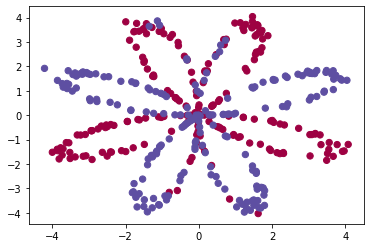

In [32]:
# Se muestran los datos
plt.scatter(X[:,0], X[:,1], c=Y.flatten(), s=40, cmap=plt.cm.Spectral);

### Red para clasificar los datos sintéticos

Para clasificar los datos sintéticos se utilizará una red de dos capas con la siguiente arquitectura:   

*Afin->Tanh->Afin->Sigmoide* 

**Ejercicio:** Completar la implementación de los métodos `red_dos_capas_datos_sinteticos()` utilizando los métodos *forward* y *backward* adecuados para dicha arquitectura. Como función de costo se utilizará la *entropía cruzada*.

In [83]:
def red_dos_capas_datos_sinteticos(X, Y, dims_capas, num_iter = 1000, learning_rate = 1,
                                   mostrar_costo=False, semilla=100):
    """
    Implementa una red neuronal de dos capas: Afin->Tanh->Afin->Sigmoide.
    
    Entrada:
        X: datos de entrada, de tamaño (N, d_0)
        Y: etiquetas (1 para la clase positiva y 0 para la negativa), de tamaño (N,1)
        dims_capas: dimensiones de las capas(d_0, d_1, d_2)
        num_iter: número de iteraciones del loop de optimización
        learning_rate: learning rate utilizado para la actualización mediante descenso por gradiente
        mostrar_costo: Si vale True, se muestra el costo cada 100 iteraciones 
        semilla: semilla utilizada para la generación de números aleatorios 
    Salida:
        parametros: un diccionario de python que contiene W1, W2, b1, y b2
    """
    
    np.random.seed(semilla)
    gradientes = {} # se inicializa el diccionario que almacena los gradiantes
    costos = []     # lista que almacena el costo
    N = X.shape[0]  # número de muestras
    d_0, d_1, d_2 = dims_capas  
    
    # Se inicializan los parámetros del diccionario llamando a una de las 
    # funciones previamente implementadas
    parametros = inicializar_pesos(d_0, d_1, d_2, semilla=semilla)

    # Se obtienen W1, b1, W2 y b2 del diccionario de parámetros.
    W1 = parametros["W1"]
    b1 = parametros["b1"]
    W2 = parametros["W2"]
    b2 = parametros["b2"]

    # Loop (descenso por gradiente)

    for i in range(0, num_iter):

        ####################################################################################
        ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
        ####################################################################################
      
        # Propagación hacia adelante: Afin -> Tanh -> Afin -> Sigmoide. 
        # Entradas: "X, W1, b1". Salidas: "X1, cache1, X2, cache2".
        X1, cache1 = afin_activacion_forward(X, W1, b1, 'tanh')
        X2, cache2 = afin_activacion_forward(X1, W2, b2, 'sigmoide')
        
        # Se calcula el costo y se inicia la propagación hacia atrás
        costo, dX2 = entropia_cruzada(X2, Y)

        
        # Propagación hacia atrás. 
        # Entradas: "dX2, cache2, cache1". Salidas: "dX1, dW2, db2, dW1, db1, dX0 (no utilizado)".
        # print('dX2 shape:', dX2.shape)
        
        dX1, dW2, db2 = afin_activacion_backward(dX2, cache2, 'sigmoide')
        dX0, dW1, db1 = afin_activacion_backward(dX1, cache1, 'tanh')
        
        # Se almacenan los gradientes recientemente calculados en el diccionario 
        gradientes = {'dX0': dX0,
                      'dW1': W1,
                      'db1': b1,
                      'dX1': dX1,
                      'dW2': W2,
                      'db2': b2}
        
        # Se actualizan los parámetros
        parametros = actualizar_parametros(parametros, gradientes, learning_rate)
        
        # Se obtienen los nuevos W1, b1, W2 y b2 del diccionario de parámetros.
        W1 = parametros["W1"]
        b1 = parametros["b1"]
        W2 = parametros["W2"]
        b2 = parametros["b2"]
        
        ####################################################################################
        ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
        ####################################################################################

        # Se muestra la evolución del costo cada 100 iteraciones
        if mostrar_costo and i % 100 == 0:
            print("Costo luego de iteracion {}: {}".format(i, np.squeeze(costo)))

        if mostrar_costo and i % 100 == 0:
            costos.append(costo)
    print(costos)     
    # se muestra el costo
    plt.plot(np.squeeze(costos))
    plt.ylabel('costo')
    plt.xlabel('iteraciones (sobre 100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parametros

In [84]:
### Se definen las constantes que determinan la arquitectura de la red ####
d_0 = X.shape[1]   
d_1 = 4
d_2 = 1
dims_capas = [d_0, d_1, d_2]

Costo luego de iteracion 0: 0.6931354295967626
Costo luego de iteracion 100: 0.6931471805599467
Costo luego de iteracion 200: 0.6931471805599467
Costo luego de iteracion 300: 0.6931471805599467
Costo luego de iteracion 400: 0.6931471805599467
Costo luego de iteracion 500: 0.6931471805599467
Costo luego de iteracion 600: 0.6931471805599467
Costo luego de iteracion 700: 0.6931471805599467
Costo luego de iteracion 800: 0.6931471805599467
Costo luego de iteracion 900: 0.6931471805599467
[array(0.69313543), array(0.69314718), array(0.69314718), array(0.69314718), array(0.69314718), array(0.69314718), array(0.69314718), array(0.69314718), array(0.69314718), array(0.69314718)]


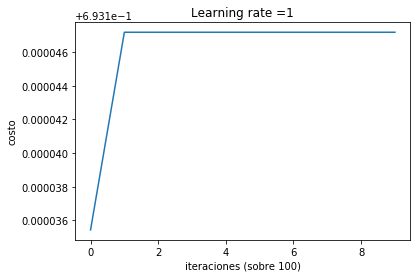

In [85]:
# Se entrena la red, con los parámetros por defecto el costo debería ser alrededor de 0.69 en la iteración 0 y 
# menor que 0.25 en la 10000
parametros_red_2capas_datos_sinteticos = red_dos_capas_datos_sinteticos(X, Y, dims_capas = [d_0, d_1, d_2], 
                                                                        num_iter = 1000, mostrar_costo=True)

### Mostrar la frontera de decisión

Para mostrar la frontera de decisión se deberá completar primero la implementación del método `predecir_clase_datos_sinteticos()`. Dicho método utiliza los parámetros de la red recientemente encontrados para predecir la clase de los vectores de características pasados como parámetro. 

In [47]:
def predecir_clase_datos_sinteticos(X, parametros):
    """
    Esta función predice la clase de los datos sintéticos. 
    
    Entrada:
        X: matriz de tamaño Nx2 que en cada fila contiene un vector de características
        parametros: parametros del modelo ya entrenado
    
    Salida:
        p : vector de tamaño Nx1 que contiene las predicciones realizadas (0 o 1)
    """
    
    # Se obtienen W1, b1, W2 y b2 del diccionario de parámetros.
    W1 = parametros["W1"]
    b1 = parametros["b1"]
    W2 = parametros["W2"]
    b2 = parametros["b2"]
    
    N = X.shape[0]
    p = np.zeros((N,1))
    
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    
    # Se hace la propagación hacia adelante de los datos de entrada X. Tener en cuenta que la
    # arquitectura utilizada en la red fue Afin-->Tanh-->Afin-->Sigmoide
    # ~ 2 lineas de codigo


    # Se obtienen las predicciones. Si la salida es mayor que 0.5 se asigna la clase 1, de lo 
    # contrario se asigna 0
    # ~ 1 linea de codigo
    
    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################

        
    return p

La siguiente celda muestra el porcentaje de acierto con el conjunto de entrenamiento. Verificar que para los parámetros por defecto es mayor al 90%.

In [48]:
predicciones_train = predecir_clase_datos_sinteticos(X, parametros_red_2capas_datos_sinteticos)
porcentaje_aciertos = np.mean(predicciones_train==Y)
print('El porcentaje de aciertos es %f' % porcentaje_aciertos)

NameError: name 'parametros_red_2capas_datos_sinteticos' is not defined

In [ ]:
# Se muestra la frontera de decisión. Verificar que es razonable para el conjunto de entrenamiento.
mostrar_frontera_decision(lambda x: predecir_clase_datos_sinteticos(x, parametros_red_2capas_datos_sinteticos), X, Y.flatten())
plt.title('Frontera de decisión para una capa oculta de ' + str(d_1) + ' nodos')

**Pregunta:** Variar la cantidad de nodos utilizados en la capa oculta y comentar sobre la influencia de dicho parámetro en la superficie de decisión obtenida.

**Respuesta:**  

...

# Clasificación de imágenes

Se utilizarán las funciones implementadas anteriormente para distinguir imágenes de *gatos* de *no gatos*.

### Los datos

La siguiente celda carga los datos. La base cuenta con conjunto de imágenes para entrenamiento y un conjunto para test. En este caso las características a utilizar son directamente los valores de los píxeles de las imágenes. 

In [14]:
from aux_datos import load_cats_dataset
features_train, y_train, features_test, y_test, clases = load_cats_dataset()
print('Se levantaron %d imágenes de entrenamiento' % len(features_train))
print('%d pertenecen a la clase %s y %d a la clase %s' % (np.sum(y_train==1),clases[0].decode("utf-8"),
                                                          np.sum(y_train==0),clases[1].decode("utf-8"))  )
print('Se levantaron %d imágenes de test' % len(features_test))
print('%d pertenecen a la clase %s y %d a la clase %s' % (np.sum(y_test==1),clases[0].decode("utf-8"),
                                                          np.sum(y_test==0),clases[1].decode("utf-8"))  )

print('Las imágenes son de tamaño [%d, %d, %d] ' % (features_train.shape[1:]))


Se levantaron 209 imágenes de entrenamiento
72 pertenecen a la clase non-cat y 137 a la clase cat
Se levantaron 50 imágenes de test
33 pertenecen a la clase non-cat y 17 a la clase cat
Las imágenes son de tamaño [64, 64, 3] 


Cada vez que se ejecuta la siguiente celda se muestra un ejemplo de cada una de las clases. 

In [ ]:
# Ejemplo de una imagen gato
indices_gatos = [i for i, label in enumerate(y_train) if label]
pos = np.random.randint(len(indices_gatos))
gato = features_train[indices_gatos[pos]]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(gato)
plt.title('Ejemplo de gato')

# Ejemplo de una imagen no gato
indices_no_gatos = [i for i, label in enumerate(y_train) if not label]
pos = np.random.randint(len(indices_no_gatos))
gato = features_train[indices_no_gatos[pos]]
plt.subplot(1,2,2)
plt.imshow(features_train[indices_no_gatos[pos]])
plt.title('Ejemplo de no gato')
plt.show()

## Red neuronal de dos capas para clasificar imágenes de gatos

**Ejercicio**: Completar la implementación de los métodos `red_dos_capas_clasifica_gatos()` utilizando los métodos *forward* y *backward* adecuados para dicha arquitectura. Como función de costo se utilizará la *entropía cruzada*. La red deberá tener la siguiente estructura: 

*AFIN -> RELU -> AFIN -> SIGMOIDE*



In [ ]:
def red_dos_capas_clasifica_gatos(X, Y, dims_capas, num_iter = 1000, learning_rate = 1,  
                                   mostrar_costo=False, semilla=100):
    """
    Implementa una red neuronal de dos capas: Afin->Relu->Afin->Sigmoide.
    
    Entrada:
        X: datos de entrada, de tamaño (N, d_0)
        Y: etiquetas (1 para la clase positiva y 0 para la negativa), de tamaño (N,1)
        dims_capas: dimensiones de las caoas(d_0, d_1, d_2)
        num_iter: número de iteraciones del loop de optimización
        learning_rate: learning rate utilizado para la actualización mediante descenso por gradiente
        mostrar_costo: Si vale True, se muestra el costo cada 100 iteraciones 
        semilla: semilla utilizada para la generación de números aleatorios 
    Salida:
        parametros: un diccionario de python que contiene W1, W2, b1, and b2
    """
    
    np.random.seed(semilla)
    gradientes = {} # se inicializa el diccionario que almacena los gradiantes
    costos = []     # lista que almacena el costo
    N = X.shape[0]  # número de muestras
    d_0, d_1, d_2 = dims_capas  
    
    # Se inicializan los parámetros del diccionario llamando a una de las 
    # funciones previamente implementadas
    parametros = inicializar_pesos(d_0, d_1, d_2, semilla=semilla)
     
    # Se obtienen W1, b1, W2 y b2 del diccionario de parámetros.
    W1 = parametros["W1"]
    b1 = parametros["b1"]
    W2 = parametros["W2"]
    b2 = parametros["b2"]
    
    # Loop (descenso por gradiente)

    for i in range(0, num_iter):

        ####################################################################################
        ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
        ####################################################################################
        
        # Propagación hacia adelante: Afin -> ReLu -> Afin -> Sigmoide. 
        # Entradas: "X, W1, b1". Salidas: "X1, cache1, X2, cache2".

        
        # Se calcula el costo y se inicia la propagación hacia atrás

        
        # Propagación hacia atrás. 
        # Entradas: "dX2, cache2, cache1". Salidas: "dX1, dW2, db2, dW1, db1, dX0 (no utilizado)".
        # print('dX2 shape:', dX2.shape)


        # Se almacenan los gradientes recientemente calculados en el diccionario 
        
        
        # Se actualizan los parámetros
        
        
        # Se obtienen los nuevos W1, b1, W2 y b2 del diccionario de parámetros.
        
        
        ####################################################################################
        ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
        ####################################################################################

        # Se muestra la evolución del costo cada 100 iteraciones
        if mostrar_costo and i % 100 == 0:
            print("Costo luego de iteracion {}: {}".format(i, np.squeeze(costo)))
            #print(W1,b1)
        if mostrar_costo and i % 100 == 0:
            costos.append(costo)
         
    # se muestra el costo
    plt.plot(np.squeeze(costos))
    plt.ylabel('costo')
    plt.xlabel('iteraciones (sobre 100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parametros

Se definen las constantes que determinan la arquitectura de la red. En este caso se usarán como características los valores de los píxeles de la imagen. La capa oculta tendrá 7 nodos y habrá un solo nodo en la capa de salida.

In [ ]:
### CONSTANTES QUE DEFINEN EL MODELO ####
d_0=features_train.shape[1]*features_train.shape[2]*features_train.shape[3]
d_1 = 7
d_2 = 1
dims_capas = [d_0, d_1, d_2]

Se hace un *reshape* de las imágenes de entrenamiento para que las entradas a la red sean vectores unidimensionales. Además se las normaliza para que los valores estén en el rango [0, 1] en vez del rango [0, 255] original.

In [ ]:
# Se hace el reshape de las características
feat_train_flat = features_train.reshape(features_train.shape[0], -1)  

# Se normalizan los datos para que las características queden en el rango [-0.5, 0.5]
train_x = feat_train_flat/255. -0.5

Ejecutar la siguiente celda y encontrar los parámetros del modelo. El costo debería decrecer con el paso de las iteraciones. Verificar que el  "Costo luego de iteracion 0" es aproximadamente 0.69, si no es así se recomienda para la ejecución con el cuadrado (⬛) de la barra superior del notebook y tratar de encontrar el error.

In [ ]:
parametros_red_gatos = red_dos_capas_clasifica_gatos(train_x, y_train, dims_capas = [d_0, d_1, d_2], 
                                                     learning_rate=0.1, num_iter = 5000, mostrar_costo=True)

Si la función de costo decreció por debajo de 0.003 al acercarse la iteración 5000 entonces la implementación es correcta y has podido entrenar la red neuronal. A continuación veremos qué tan bien funcionan los parámetros encontrados con el conjunto de entrenamiento. 

**Ejercicio:** Completar la implementación del método `clasificar_gato()` para que dado un conjunto de imágenes de entrada y los parámetros de la red encontrados durante el entrenamiento devuelva si pertenece a la clase gato o no.

In [ ]:
def clasificar_gato(X, parametros):
    """
    Esta función predice si las imágenes almacenadas en el vector X son gatos o no
    
    Entrada:
        X: matriz de tamaño N x d_0 que contiene N imágenes almacenadas una por fila
        parametros: parámetros óptimos encontrados al entrenar la red
    
    Salida:
        p: predicciones realizadas por la red para las imágenes en X (1 si es gato, 0 si no)
    """
    
    # Se obtienen W1, b1, W2 y b2 del diccionario de parámetros.
    W1 = parametros["W1"]
    b1 = parametros["b1"]
    W2 = parametros["W2"]
    b2 = parametros["b2"]
    
    N = X.shape[0]
    p = np.zeros((N,1))
    
    ####################################################################################
    ###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    
    # Se realiza la propagación hacia adelante de las imágenes de entrada
    # ~ 2 lineas de código
    
    
    # Se realiza la predicción 
    # ~ 1 línea de código

    
    ####################################################################################
    ###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
    ####################################################################################
    
        
    return p

Verificar que la red entrenada hace un trabajo fantástico con el conjunto de entrenamiento.

In [ ]:
predicciones_train = clasificar_gato(train_x, parametros_red_gatos)
accuracy_train = str(np.mean((predicciones_train == y_train)))
print("Porcentaje de acierto en entrenamiento: "  + accuracy_train)

¿Cerca del 100% de acierto? ¡Bien hecho! Excelente trabajo. Ahora sólo resta evaluar con el conjunto reservado para test.

In [ ]:
####################################################################################
###########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################
####################################################################################

# accuracy_test = 

####################################################################################
###########  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################
####################################################################################
print("Porcentaje de acierto en test: "  + accuracy_test)

¿Mucho mejor que tirar una moneda? Seguro que si.

**Ejercicio:** Comente cuáles son a su criterio las razones que explican el resultado obtenido y comente al menos un par de estrategias que de haberse implementado seguramente habrían redituado en un mejor desempeño con el conjunto de test. 

**Respuesta:** 

...

<a id="Ejercicio2"></a>
# Ejercicio 2: Jugando con Tensorflow playground

**Parte 1)** Ejecutar el [modelo parte 1](https://playground.tensorflow.org/#activation=linear&regularization=L2&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=35&networkShape=1&seed=0.68341&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false&discretize_hide=false) y corroborar que no es capaz de separar correctamente los datos. Explicar.

**Respuesta:** \
No le da la cantidad de perceptrones para implementar la complejidad de la funcion objetivo. \
Despues de 250 epocas  Test loss 0.527
                       Training loss 0.493


|  Epocas  |  Test Loss  |  Training Loss |
| -------- |    ------   |     ----       |
| 250      |   0.527     |   0.493        |

**Parte 2)** Aumentar el número de neuronas en capa oculta a dos. ¿Se pueden separar los datos? 

**Respuesta:** \
Aun no. Tendrá algo que ver con que la función de activacion es lineal y los datos no (tiene ruido)?? **DUDA**\

|  Epocas  |  Test Loss  |  Training Loss |
| -------- |    ------   |     ----       |
| 250      |   0.508     |   0.498        |

**Parte 3)** Aumentar el número de neuronas en capa oculta a tres utilizando como función de activación ReLU. ¿Es este modelo adecuado para separar los datos? Ejecutar varias veces cambiando la inicialización.

**Respuesta:** 

| Iteracion |  Epocas  |  Test Loss  |  Training Loss |
|  ------   | -------- |    ------   |     ----       |
|     1     | 400      |   0.336     |   0.337        |
|     2     | 290      |   0.174     |   0.144        |
|     3     | 350      |   0.209     |   0.162        |


**Parte 4)** Probar ahora con la siguiente arquitectura:
- Primera capa oculta con tres neuronas
- Segunda capa oculta con tres neuronas
- Tercera capa oculta con dos neuronas

¿Este modelo se ajusta mejor a los datos? ¿Converge más rápido y con mayor asiduidad que el de la parte 3? A los efectos de este ejercicio consideraremos que el modelo converge si el error de test es menor a 0.177.

**Respuesta:** 

| Iteracion |  Epocas  |  Test Loss  |  Training Loss |
|  ------   | -------- |    ------   |     ----       |
|     1     | 300      |   0.220     |   0.154        |
|     2     | 500      |   0.153     |   0.136        |
|     3     | 430      |   0.194     |   0.147        |
|     4     | 800      |   0.180     |   0.156        |
|     5     | 500      |   0.135     |   0.102        |


No noto mejora considerable al caso de la part 3

**Parte 5)** Utilizando sólamente $X_1$ y $X_2$ como características construir un modelo que separe adecuadamente los datos con [distribución en espiral](https://playground.tensorflow.org/#activation=linear&regularization=L2&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.63187&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false&discretize_hide=false). Para ello puede variar libremente el número de capas ocultas y la cantidad de nodos por capa oculta. Indique además los valores elegidos para los siguientes parámetros y las razones que guiaron la elección:
- learning rate
- activación
- tipo de regularización
- factor de regularización

**Respuesta:** \

```Primer modelo:``` _lr = 0.1 | activacion=ReLU | Regularization=L2 | Regularization rate=0_

| # capas ocultas |  Neuronas/capa  | Epocas  | Test Loss  |  Training Loss |
|  ------------   |  -------------- |  -----  |   ------   |     ----       |
|     2           |      (8,8)      |    1500 |  0.065     |   0.048        |
|     3           |      (4,4,4)    |    1000 |  0.033     |   0.008        |
|     3           |      (8,8,8)    |    250  |  0.019     |   0.000        |
|     3           |      (6,6,6)    |    250  |  0.013     |   0.001        |
|     3           |      (5,5,5)    |    530  |  0.016     |   0.001        |

```Segundo modelo:``` _lr = 0.1 | activacion=tanh | Regularization=L2 | Regularization rate=0_

| # capas ocultas |  Neuronas/capa  | Epocas  | Test Loss  |  Training Loss |
|  ------------   |  -------------- |  -----  |   ------   |     ----       |
|     3           |      (8,8,8)    |    300  |  0.019     |   0.001        |
|     3           |      (8,8,8)    |    600  |  0.055     |   0.000        |


Del ```primer modelo```, el que dio Training Loss=0.000 le agrego Regularization rate

| # capas ocultas |  Neuronas/capa  | Epocas  | Test Loss  |  Training Loss |  Regularization rate |
|  ------------   |  -------------- |  -----  |   ------   |     ----       |     --------------   |
|     3           |      (8,8,8)    |    250  |  0.010     |   0.002        |       0.001          |
|     3           |      (8,8,8)    |    250  |  0.086     |   0.065        |       0.01           |
|     3           |      (6,6,6)    |    700  |  0.014     |   0.006        |       0.001          |


**Parte 6)** La extracción de características puede ser útil aún cuando se trabaja con clasificadores de gran capacidad expresiva como las redes neuronales. Utilizando las transformaciones de características a la entrada que considere convenientes, encontrar la arquitectura de red con menor cantidad de nodos que produzca un error con el conjunto de test menor a 0.1. *Sugerencia:*  guarde registro del momento. 

**Respuesta:**\

Las caracteristicas que hasta ahora me han dado mas resultado son $X^1$, $X^2$, $X^{12}$, $X^{22}$, $X^1X^2$ :

|   Lr     |  Activacion  |  Regul. rate  | # Capas  |  #nodos/capa | Epocas  |   Test loss   | Training loss |
|  -----   |  ----------- |   ----------  | ------   |     ----     | ------- | ------------- | ------------- |
|    0.1   |     ReLU     |      0.001    |   2      |      (8,8)   |  160    |      0.011    |     0.005     |
|     "    |       "      |        "      |    "     |      (6,6)   |  165    |      0.010    |    0.006      |
|     "    |       "      |        "      |    "     |      (4,4)   |  630    |      0.035    |     0.021     |
|     "    |       "      |        "      |    "     |      (5,4)   |  300    |      0.032    |     0.014     |

   